In [86]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
import scipy.stats as stat
import re

import warnings
# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## AD specificity

In [132]:
adsmapped = pd.read_csv("maps/ADs_mapped.tsv", sep="\t", quoting=3)
ads_specificity = pd.read_csv("../cofactors_humanproteinatlas/helperdata/AD_specificity.csv").drop("Unnamed: 0", axis=1)

#Clean TAU columns
for col_label in ads_specificity.columns.to_list():
    if "TAU" in col_label:
        ads_specificity[col_label] = ads_specificity[col_label].apply(lambda x: np.NaN if x == "Not detected" or x == "Not available" else float(x))

adsmapped["Bgee"] = [str(i).replace(";", "") for i in adsmapped["Bgee"]]
ads = adsmapped.merge(ads_specificity, left_on="Bgee", right_on="Ensembl", how="left").drop_duplicates()
ads.head()

,From,Entry,Entry Name,Protein names,Gene Names,Sequence,Bgee,Ensembl_x,GeneID,PDB,...,RNA single cell type specific nTPM,RNA single nuclei brain specificity,RNA single nuclei brain distribution,RNA single nuclei brain specificity score,RNA single nuclei brain specific nTPM,TAU score - Tissue,TAU score - Blood,TAU score - Brain,TAU score - Single Cell Type,TAU score - Single nuclei brain
0,Q6UWZ7,Q6UWZ7,ABRX1_HUMAN,BRCA1-A complex subunit Abraxas 1 (Coiled-coil...,ABRAXAS1 ABRA1 CCDC98 FAM175A UNQ496/PRO1013,MEGESTSAVLSGFVLGALAFQHLNTDSDTEGFLLGEVKGEAKNSIT...,ENSG00000163322,ENST00000321945.12 [Q6UWZ7-1];,84142;,4JLU;4U4A;4Y18;4Y2G;,...,"{'Early spermatids': '92.3', 'Spermatocytes': ...",Cell type enriched,Detected in all,4.0,{'choroid plexus epithelial cell': '109.0'},0.36,0.31,0.15,0.47,0.52
1,Q8IUX7,Q8IUX7,AEBP1_HUMAN,Adipocyte enhancer-binding protein 1 (AE-bindi...,AEBP1 ACLP,MAAVRGAPLLSCLLALLALCPGGRPQTVLTDDEIEEFLEGFLSELE...,ENSG00000106624,ENST00000223357.8 [Q8IUX7-1];ENST00000450684.2...,165;,NaN,...,"{'Fibroblasts': '277.4', 'Leydig cells': '148....",Group enriched,Detected in many,13.0,"{'astrocyte': '112.8', 'ependymal cell': '79.3...",0.27,0.89,0.18,0.71,0.77
2,Q8WYP5,Q8WYP5,ELYS_HUMAN,Protein ELYS (Embryonic large molecule derived...,AHCTF1 ELYS TMBS62 MSTP108,MRDLRAQVTSGLLPFPEVTLQALGEDEITLESVLRGKFAAGKNGLA...,ENSG00000153207,ENST00000326225.3 [Q8WYP5-3];ENST00000366508.5...,25909;,7R5J;7R5K;,...,"{'monocytes': '91.1', 'Spermatocytes': '96.9'}",Low cell type specificity,Detected in all,NaN,NaN,0.34,0.70,0.14,0.36,0.08
6,P35869,P35869,AHR_HUMAN,Aryl hydrocarbon receptor (Ah receptor) (AhR) ...,AHR BHLHE76,MNSSSANITYASRKRRKPVQKTVKPIPAEGIKSNPSKRHRDRLNTE...,ENSG00000106546,ENST00000242057.9;ENST00000463496.1;,196;,5NJ8;7ZUB;8QMO;,...,"{'granulocytes': '187.3', 'Langerhans cells': ...",Cell type enhanced,Detected in many,NaN,{'hippocampal dentate gyrus': '46.1'},0.36,0.58,0.18,0.48,0.49
10,O43918,O43918,AIRE_HUMAN,Autoimmune regulator (Autoimmune polyendocrino...,AIRE APECED,MATDAALRRLLRLHRTEIAVAVDSAFPLLHALADHDVVPEDKFQET...,ENSG00000160224,ENST00000291582.6 [O43918-1];,326;,1XWH;2KE1;2KFT;2LRI;,...,"{'Excitatory neurons': '1.1', 'Horizontal cell...",Cell type enhanced,Detected in many,NaN,"{'deep-layer near-projecting': '9.8', 'fibrobl...",0.90,NaN,0.26,0.91,0.71


In [185]:
ads_scRNA = pd.read_csv("../cofactors_humanproteinatlas/helperdata/AD_scRNA.csv").drop("Unnamed: 0", axis=1)

In [234]:
len(rdsmapped)

1695

In [134]:
def cleanmotif(text):
    # Extract positions and notes
    positions = re.findall(r'MOTIF (\d+)\.\.(\d+);', text)
    descriptions = re.findall(r'/note="([^"]+)"', text)
    # Convert positions to tuples of integers
    positions = [(int(start), int(end)) for start, end in positions]
    # Clean descriptions (remove trailing numbering)
    cleaned_descriptions = [re.sub(r'\s\d+$', '', desc) for desc in descriptions]
    return cleaned_descriptions, positions

def cleandomain(text):
    # Extract positions and notes
    positions = re.findall(r'DOMAIN (\d+)\.\.(\d+);', text)
    descriptions = re.findall(r'/note="([^"]+)"', text)
    # Convert positions to tuples of integers
    positions = [(int(start), int(end)) for start, end in positions]
    # Clean descriptions (remove trailing numbering)
    cleaned_descriptions = [re.sub(r'\s\d+$', '', desc) for desc in descriptions]
    return cleaned_descriptions, positions

def cleancompbias(text):
    # Extract positions and notes
    positions = re.findall(r'COMPBIAS (\d+)\.\.(\d+);', text)
    descriptions = re.findall(r'/note="([^"]+)"', text)
    # Convert positions to tuples of integers
    positions = [(int(start), int(end)) for start, end in positions]
    # Clean descriptions (remove trailing numbering)
    cleaned_descriptions = [re.sub(r'\s\d+$', '', desc) for desc in descriptions]
    return cleaned_descriptions, positions



def RNAcellspecificity(df):
    """
    Generates a DF cell specificity genes
    """
    df = df[["Gene", "RNA single cell type specific nTPM"]]

    cellspecific_cells = pd.DataFrame({"Cell Type": [], "Genes": []}).set_index("Cell Type")

    for _, row in df.iterrows():
        celldict = row["RNA single cell type specific nTPM"]
        if pd.notna(celldict):
            cell_dict = ast.literal_eval(celldict)
            for cell, _ in cell_dict.items():
                if cell not in cellspecific_cells.index.to_list():
                    cellspecific_cells.loc[cell] = [[]]
                cellspecific_cells.at[cell, "Genes"].append(row["Gene"])

    return cellspecific_cells


In [217]:
def categoricalpivot(indexlabel, columnlabel, cleanfunction, df_input, unique):
    df = df_input[["Entry", indexlabel, columnlabel]]
    df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
    if unique:
        df[columnlabel] = df[columnlabel].apply(lambda x: list(set(x)))
    df = df.explode(columnlabel).pivot_table(index=indexlabel, columns=columnlabel, values="Entry", aggfunc="count").fillna(0)
    return df

def categoricalpivot_doubleexplode(indexlabel, columnlabel, cleanfunction, df_input, unique):
    df = df_input[["TAU score - Single Cell Type", indexlabel, columnlabel]]
    df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
    df[[indexlabel, 'Positions']] = df[indexlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
    if unique:
        df[columnlabel] = df[columnlabel].apply(lambda x: list(set(x)))
    df = df.explode(columnlabel).explode(indexlabel)
    df = df.pivot_table(index=indexlabel, columns=columnlabel, values="TAU score - Single Cell Type", aggfunc="mean").fillna(0)
    return df

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/350604041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/350604041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

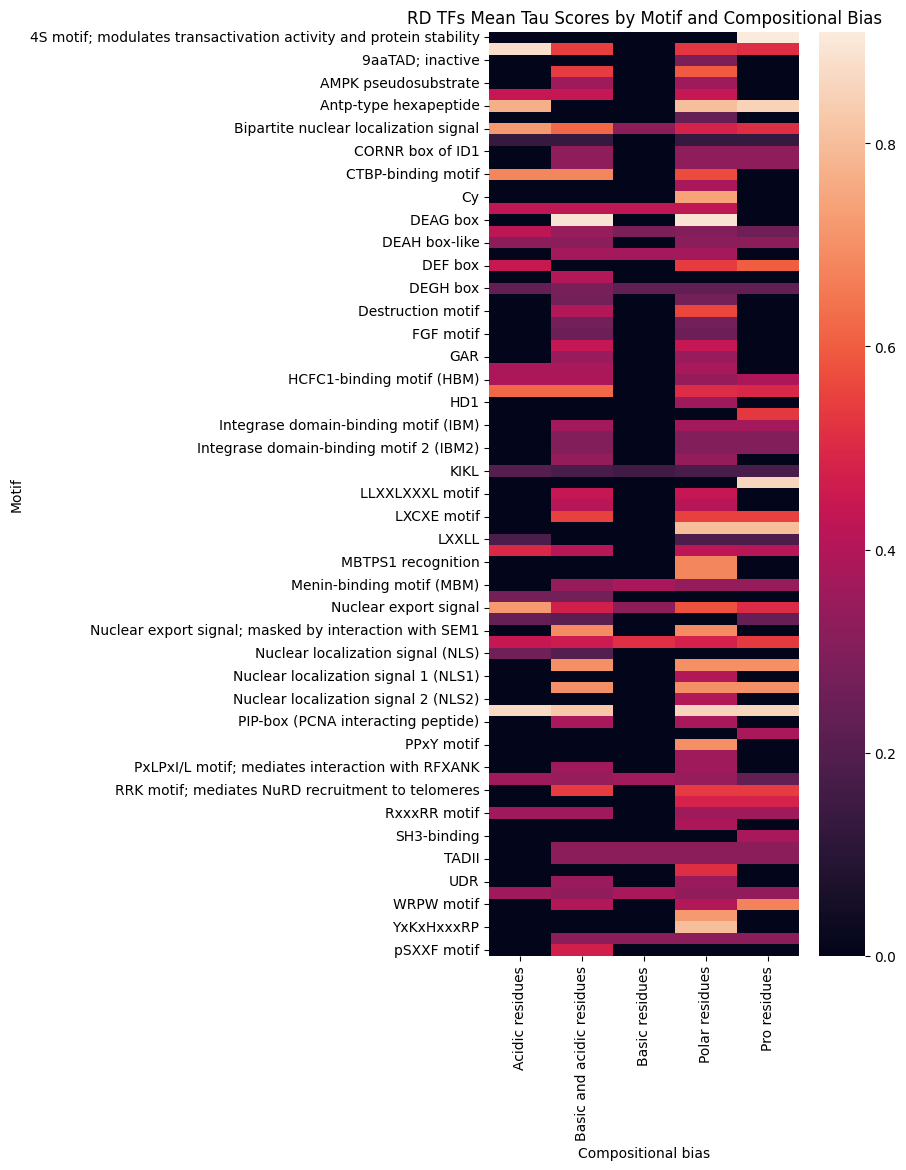

In [236]:
plt.figure(figsize=(5, 12))
sns.heatmap(categoricalpivot_doubleexplode("Motif", "Compositional bias", cleanmotif, rds, True))
plt.title("RD TFs Mean Tau Scores by Motif and Compositional Bias")
plt.savefig("figures/RDmotifcompositiontau.png")

In [197]:
ads.columns

Index(['From', 'Entry', 'Entry Name', 'Protein names', 'Gene Names',
       'Sequence', 'Bgee', 'Ensembl_x', 'GeneID', 'PDB', 'Reviewed', 'Motif',
       'Protein families', 'Domain [CC]', 'Domain [FT]', 'Compositional bias',
       'Sequence similarities', 'BioGRID', 'Post-translational modification',
       'Gene', 'Ensembl_y', 'RNA tissue specificity',
       'RNA tissue distribution', 'RNA tissue specificity score',
       'RNA tissue specific nTPM', 'RNA single cell type specificity',
       'RNA single cell type distribution',
       'RNA single cell type specificity score',
       'RNA single cell type specific nTPM',
       'RNA single nuclei brain specificity',
       'RNA single nuclei brain distribution',
       'RNA single nuclei brain specificity score',
       'RNA single nuclei brain specific nTPM', 'TAU score - Tissue',
       'TAU score - Blood', 'TAU score - Brain',
       'TAU score - Single Cell Type', 'TAU score - Single nuclei brain'],
      dtype='object')

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

<Figure size 1800x500 with 0 Axes>

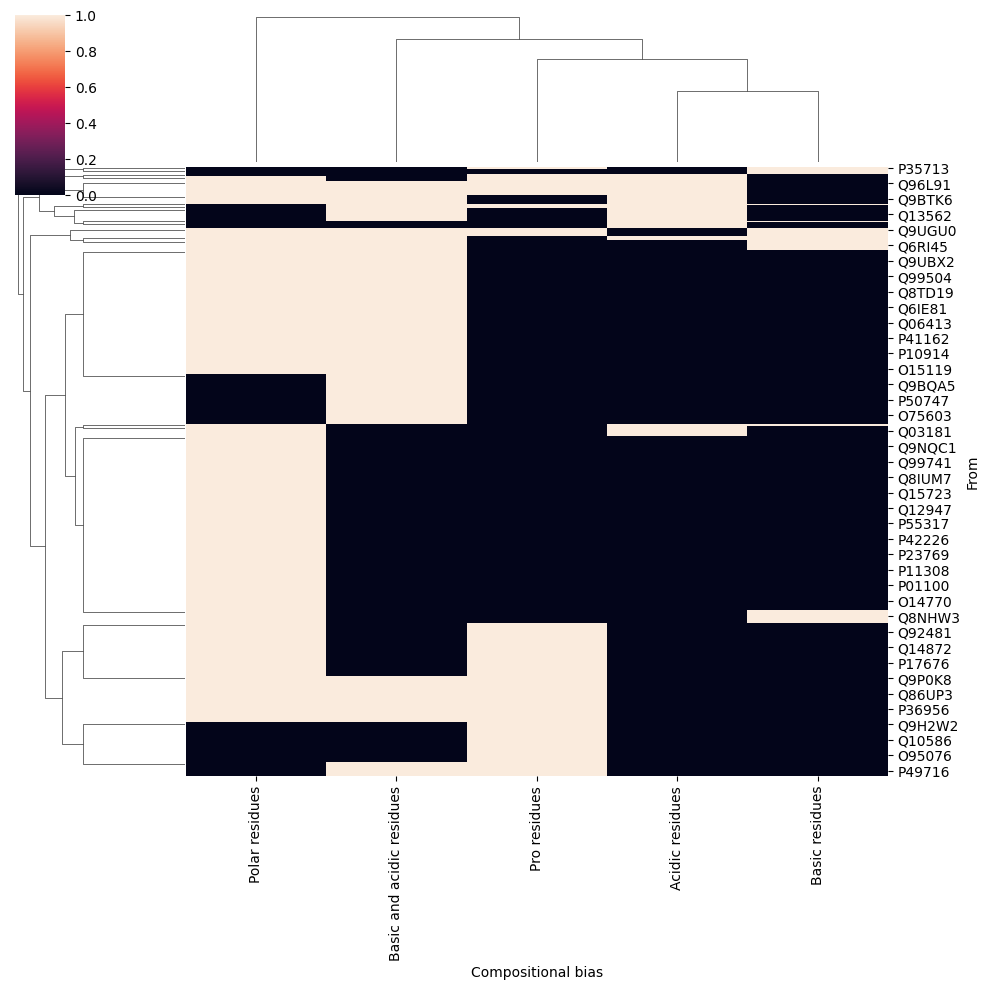

In [202]:
plt.figure(figsize=(18, 5))
sns.clustermap(categoricalpivot("From", "Compositional bias", cleancompbias, ads, True))

In [142]:
adscellspecific = ads[ads["TAU score - Single Cell Type"] > 0.4]
adscellspecific_grouped = RNAcellspecificity(adscellspecific)
adscellspecific_exploded = adscellspecific_grouped.explode("Genes").reset_index().merge(ads, left_on="Genes", right_on="Gene", how="left")
adscellspecific_exploded.head()

,Cell Type,Genes,From,Entry,Entry Name,Protein names,Gene Names,Sequence,Bgee,Ensembl_x,...,RNA single cell type specific nTPM,RNA single nuclei brain specificity,RNA single nuclei brain distribution,RNA single nuclei brain specificity score,RNA single nuclei brain specific nTPM,TAU score - Tissue,TAU score - Blood,TAU score - Brain,TAU score - Single Cell Type,TAU score - Single nuclei brain
0,Early spermatids,ABRAXAS1,Q6UWZ7,Q6UWZ7,ABRX1_HUMAN,BRCA1-A complex subunit Abraxas 1 (Coiled-coil...,ABRAXAS1 ABRA1 CCDC98 FAM175A UNQ496/PRO1013,MEGESTSAVLSGFVLGALAFQHLNTDSDTEGFLLGEVKGEAKNSIT...,ENSG00000163322,ENST00000321945.12 [Q6UWZ7-1];,...,"{'Early spermatids': '92.3', 'Spermatocytes': ...",Cell type enriched,Detected in all,4.0,{'choroid plexus epithelial cell': '109.0'},0.36,0.31,0.15,0.47,0.52
1,Early spermatids,APBB3,O95704,O95704,APBB3_HUMAN,Amyloid-beta A4 precursor protein-binding fami...,APBB3 FE65L2,MLGKDYMLAIILVNCDDDLWGDHSLEVEAGLPPGWRKIHDAAGTYY...,ENSG00000113108,ENST00000354402.9 [O95704-4];ENST00000356738.6...,...,"{'Early spermatids': '62.5', 'Late spermatids'...",Low cell type specificity,Detected in all,NaN,NaN,0.63,0.74,0.20,0.49,0.22
2,Early spermatids,APOBEC4,Q8WW27,Q8WW27,ABEC4_HUMAN,Putative C->U-editing enzyme APOBEC-4 (EC 3.5....,APOBEC4 C1orf169,MEPIYEEYLANHGTIVKPYYWLSFSLDCSNCPYHIRTGEEARVSLT...,ENSG00000173627,ENST00000308641.6;,...,"{'Ciliated cells': '32.6', 'Early spermatids':...",Low cell type specificity,Detected in many,NaN,NaN,0.95,NaN,0.27,0.96,0.49
3,Early spermatids,ASXL3,Q9C0F0,Q9C0F0,ASXL3_HUMAN,Putative Polycomb group protein ASXL3 (Additio...,ASXL3 KIAA1713,MKDKRKKKDRTWAEAARLALEKHPNSPMTAKQILEVIQKEGLKETS...,ENSG00000141431,ENST00000269197.12 [Q9C0F0-1];,...,"{'Early spermatids': '65.6', 'Excitatory neuro...",Low cell type specificity,Detected in all,NaN,NaN,0.66,NaN,0.21,0.82,0.27
4,Early spermatids,ATMIN,O43313,O43313,ATMIN_HUMAN,ATM interactor (ATM/ATR-substrate CHK2-interac...,ATMIN KIAA0431 ZNF822,MAASEAAAAAGSAALAAGARAVPAATTGAAAAASGPWVPPGPRLRG...,ENSG00000166454,ENST00000299575.5 [O43313-1];ENST00000564241.5...,...,"{'Early spermatids': '154.4', 'Late spermatids...",Low cell type specificity,Detected in all,NaN,NaN,0.18,0.35,0.05,0.48,0.15


<Axes: xlabel='Count', ylabel='Cell Type'>

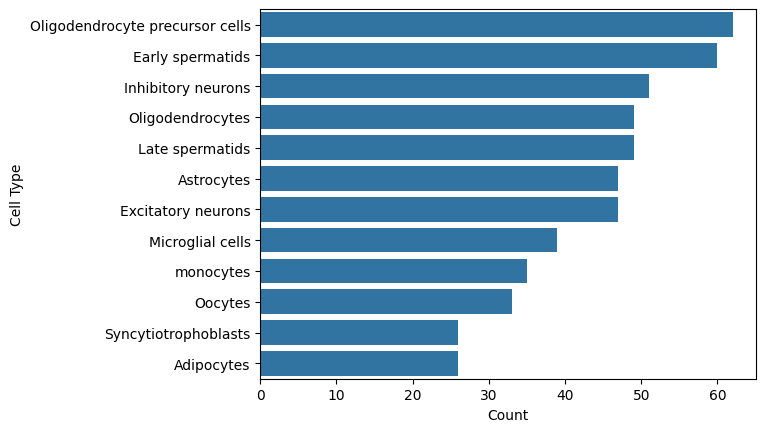

In [168]:
ad_cellspecific_counts = adscellspecific_exploded.groupby("Cell Type").agg("count").sort_values("Genes", ascending=False).rename({"Genes": "Count"}, axis=1)[["Count"]].reset_index()
sns.barplot(ad_cellspecific_counts[ad_cellspecific_counts["Count"] > 25], y = "Cell Type", x="Count", orient="h")

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

<Axes: xlabel='Motif', ylabel='Cell Type'>

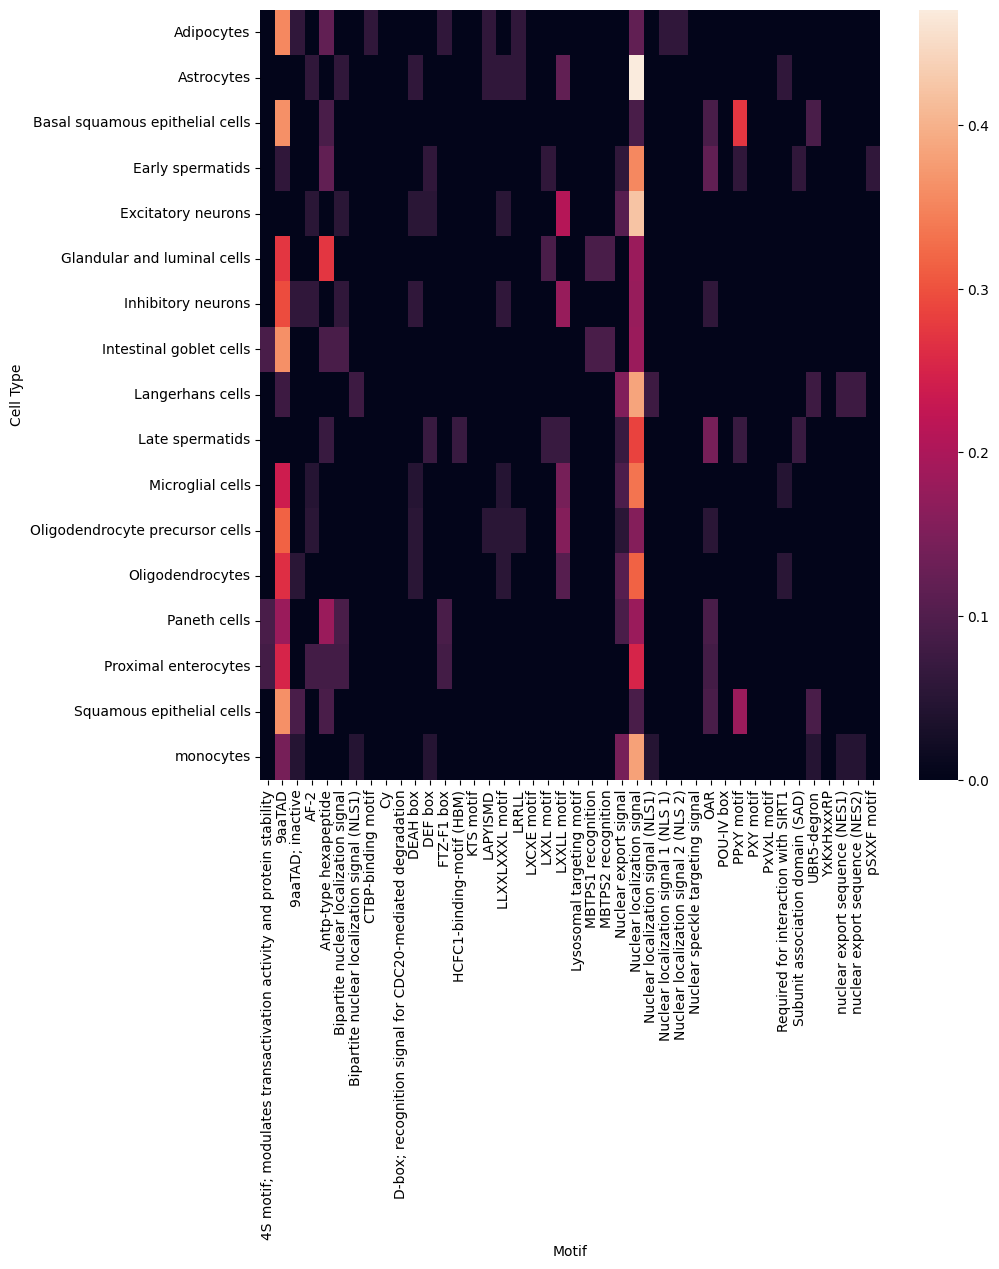

In [158]:
adTFmotifs = categoricalpivot("Cell Type", "Motif", cleanmotif, adscellspecific_exploded, True)
adTFmotifs_filtered = adTFmotifs[adTFmotifs.sum(axis=1) > 10]
adTFmotifs_filtered = adTFmotifs_filtered.div(adTFmotifs_filtered.sum(axis=1), axis=0)
plt.figure(figsize=(10, 10))
sns.heatmap(adTFmotifs_filtered)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

<Figure size 500x1500 with 0 Axes>

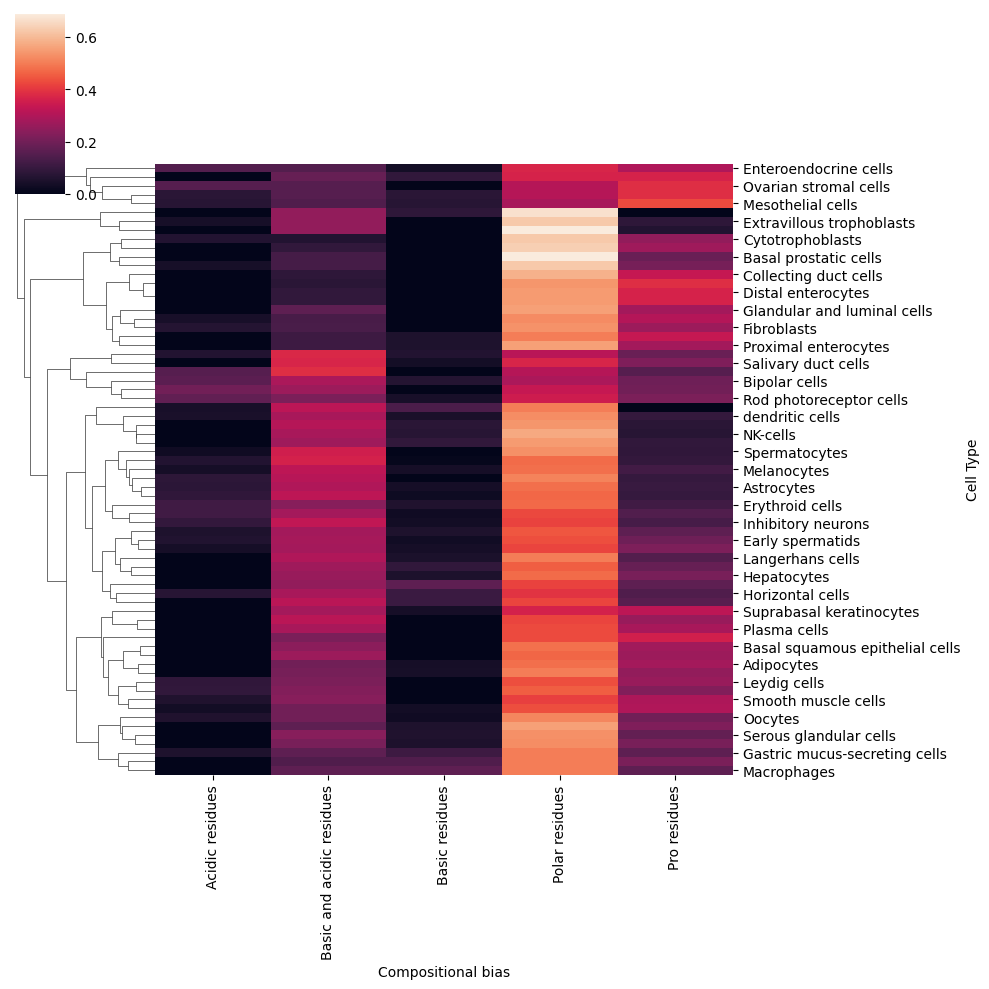

In [205]:
adTFmotifs = categoricalpivot("Cell Type", "Compositional bias", cleancompbias, adscellspecific_exploded, True)
adTFmotifs_filtered = adTFmotifs[adTFmotifs.sum(axis=1) > 10]
adTFmotifs_filtered = adTFmotifs_filtered.div(adTFmotifs_filtered.sum(axis=1), axis=0)
plt.figure(figsize=(5, 15))
sns.clustermap(adTFmotifs_filtered, col_cluster=False)

---
## RDs

In [71]:
rds_scRNA = pd.read_csv("../cofactors_humanproteinatlas/helperdata/RD_scRNA.csv").drop("Unnamed: 0", axis=1)

In [73]:
rdsmapped = pd.read_csv("maps/RDs_mapped.tsv", sep="\t", quoting=3)
rds_specificity = pd.read_csv("../cofactors_humanproteinatlas/helperdata/RD_specificity.csv").drop("Unnamed: 0", axis=1)

#Clean TAU columns
for col_label in rds_specificity.columns.to_list():
    if "TAU" in col_label:
        rds_specificity[col_label] = rds_specificity[col_label].apply(lambda x: np.NaN if (x == "Not detected") or (x == "Not available") else float(x))

rdsmapped["Bgee"] = [str(i).replace(";", "") for i in rdsmapped["Bgee"]]
rds = rdsmapped.merge(rds_specificity, left_on="Bgee", right_on="Ensembl", how="left").drop_duplicates()


rds.head()

,From,Entry,Entry Name,Protein names,Gene Names,Sequence,Bgee,Ensembl_x,GeneID,PDB,...,RNA single cell type specific nTPM,RNA single nuclei brain specificity,RNA single nuclei brain distribution,RNA single nuclei brain specificity score,RNA single nuclei brain specific nTPM,TAU score - Tissue,TAU score - Blood,TAU score - Brain,TAU score - Single Cell Type,TAU score - Single nuclei brain
0,A0A024R0Y4,A0A024R0Y4,A0A024R0Y4_HUMAN,Transcriptional adapter,TADA2A TADA2L hCG_28187,MDRLGSFSNDPSDKPPCRGCSSYLMEPYIKCAECGPPPFFLCLQCF...,ENSG00000276234,ENST00000612272.4;ENST00000615182.5;ENST000006...,6871;,NaN,...,{'Late spermatids': '131.9'},Low cell type specificity,Detected in all,NaN,NaN,0.37,0.30,0.12,0.55,0.13
1,A0A087X169,A0A087X169,A0A087X169_HUMAN,PHD finger protein 19,PHF19,MLVLVIRGPYPSAQCQGKLMENRALDPGTRDSYGATSHLPNKGALA...,ENSG00000119403,ENST00000616568.5;,26147;,NaN,...,"{'Langerhans cells': '44.2', 'monocytes': '79....",Cell type enhanced,Detected in all,NaN,{'leukocyte': '27.8'},0.31,0.53,0.17,0.55,0.51
5,A0A0A0MRP6,A0A0A0MRP6,A0A0A0MRP6_HUMAN,"SWI/SNF related, matrix associated, actin depe...",SMARCA1,MEQDTAAVAATVAAADATATIVVIEDEQPGPSTSQEEGAAAAATEA...,ENSG00000102038,ENST00000371123.5;,6594;,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,A0A0B4J2G0,A0A0B4J2G0,A0A0B4J2G0_HUMAN,Zinc finger protein 107,ZNF107,MEPLTFKDVAIEFSLEEWQCLDTAQRDLYRNVLLENYRNLVFLGIA...,ENSG00000196247,ENST00000620827.6;,51427;,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A0A0C4DFL8,A0A0C4DFL8,A0A0C4DFL8_HUMAN,[histone H3]-trimethyl-L-lysine(9) demethylase...,KDM4B,MGSEDHGAQNPSCKIMTFRPTMEEFKDFNKYVAYIESQGAHRAGLA...,ENSG00000127663,ENST00000159111.9;,23030;,NaN,...,NaN,Low cell type specificity,Detected in all,NaN,NaN,0.23,0.67,0.09,0.33,0.09


In [76]:
rdscellspecific = rds[rds["TAU score - Single Cell Type"] > 0.4]
rdscellspecific_grouped = RNAcellspecificity(rdscellspecific)
rdscellspecific_exploded = rdscellspecific_grouped.explode("Genes").reset_index().merge(rds, left_on="Genes", right_on="Gene", how="left")
rdscellspecific_exploded.head()


,Cell Type,Genes,From,Entry,Entry Name,Protein names,Gene Names,Sequence,Bgee,Ensembl_x,...,RNA single cell type specific nTPM,RNA single nuclei brain specificity,RNA single nuclei brain distribution,RNA single nuclei brain specificity score,RNA single nuclei brain specific nTPM,TAU score - Tissue,TAU score - Blood,TAU score - Brain,TAU score - Single Cell Type,TAU score - Single nuclei brain
0,Late spermatids,TADA2A,A0A024R0Y4,A0A024R0Y4,A0A024R0Y4_HUMAN,Transcriptional adapter,TADA2A TADA2L hCG_28187,MDRLGSFSNDPSDKPPCRGCSSYLMEPYIKCAECGPPPFFLCLQCF...,ENSG00000276234,ENST00000612272.4;ENST00000615182.5;ENST000006...,...,{'Late spermatids': '131.9'},Low cell type specificity,Detected in all,NaN,NaN,0.37,0.30,0.12,0.55,0.13
1,Late spermatids,ESRRB,A0A2R8Y491,A0A2R8Y491,A0A2R8Y491_HUMAN,Estrogen related receptor beta,ESRRB,MDVSELCIPDPLGYHNQLLNRMSSDDRHLGSSCGSFIKTEPSSPSS...,ENSG00000119715,ENST00000644823.1;,...,"{'Distal tubular cells': '9.2', 'Early spermat...",Group enriched,Detected in many,4.0,"{'central nervous system macrophage': '23.6', ...",0.91,NaN,0.29,0.90,0.58
2,Late spermatids,DPRX,A6NFQ7,A6NFQ7,DPRX_HUMAN,Divergent paired-related homeobox,DPRX,MPGSEDLRKGKDQMHSHRKRTMFTKKQLEDLNILFNENPYPNPSLQ...,ENSG00000204595,ENST00000376650.2;ENST00000710707.1;,...,"{'Adipocytes': '1.3', 'Cytotrophoblasts': '1.1...",Not detected,Not detected,NaN,NaN,0.81,NaN,NaN,0.95,NaN
3,Late spermatids,DRGX,A6NNA5,A6NNA5,DRGX_HUMAN,Dorsal root ganglia homeobox protein (Paired-r...,DRGX PRRXL1,MFYFHCPPQLEGTATFGNHSSGDFDDGFLRRKQRRNRTTFTLQQLE...,ENSG00000165606,ENST00000374139.8;,...,"{'Langerhans cells': '2.0', 'Late spermatids':...",Group enriched,Detected in some,5.0,"{'lower rhombic lip': '17.0', 'splatter': '9.2'}",0.95,NaN,0.72,0.95,0.90
4,Late spermatids,L3MBTL4,F8W9S8,F8W9S8,F8W9S8_HUMAN,L3MBTL histone methyl-lysine binding protein 4,L3MBTL4,MKQPNRKRKLNMDSKERLDQDGRLEQAEEEKKPKDSTTPLSHVPSA...,ENSG00000154655,ENST00000317931.12;,...,"{'Inhibitory neurons': '152.8', 'Late spermati...",Low cell type specificity,Detected in all,NaN,NaN,0.44,0.78,0.16,0.68,0.29


In [145]:
rdmotifpivot = categoricalpivot("Cell Type", "Motif", cleanmotif, rdscellspecific_exploded, True)
rddomainpivot = categoricalpivot("Cell Type", "Domain [FT]", cleandomain, rdscellspecific_exploded, True)
rdcompbiaspivot = categoricalpivot("Cell Type", "Compositional bias", cleancompbias, rdscellspecific_exploded, True)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/3398988900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

<Axes: xlabel='Motif', ylabel='Cell Type'>

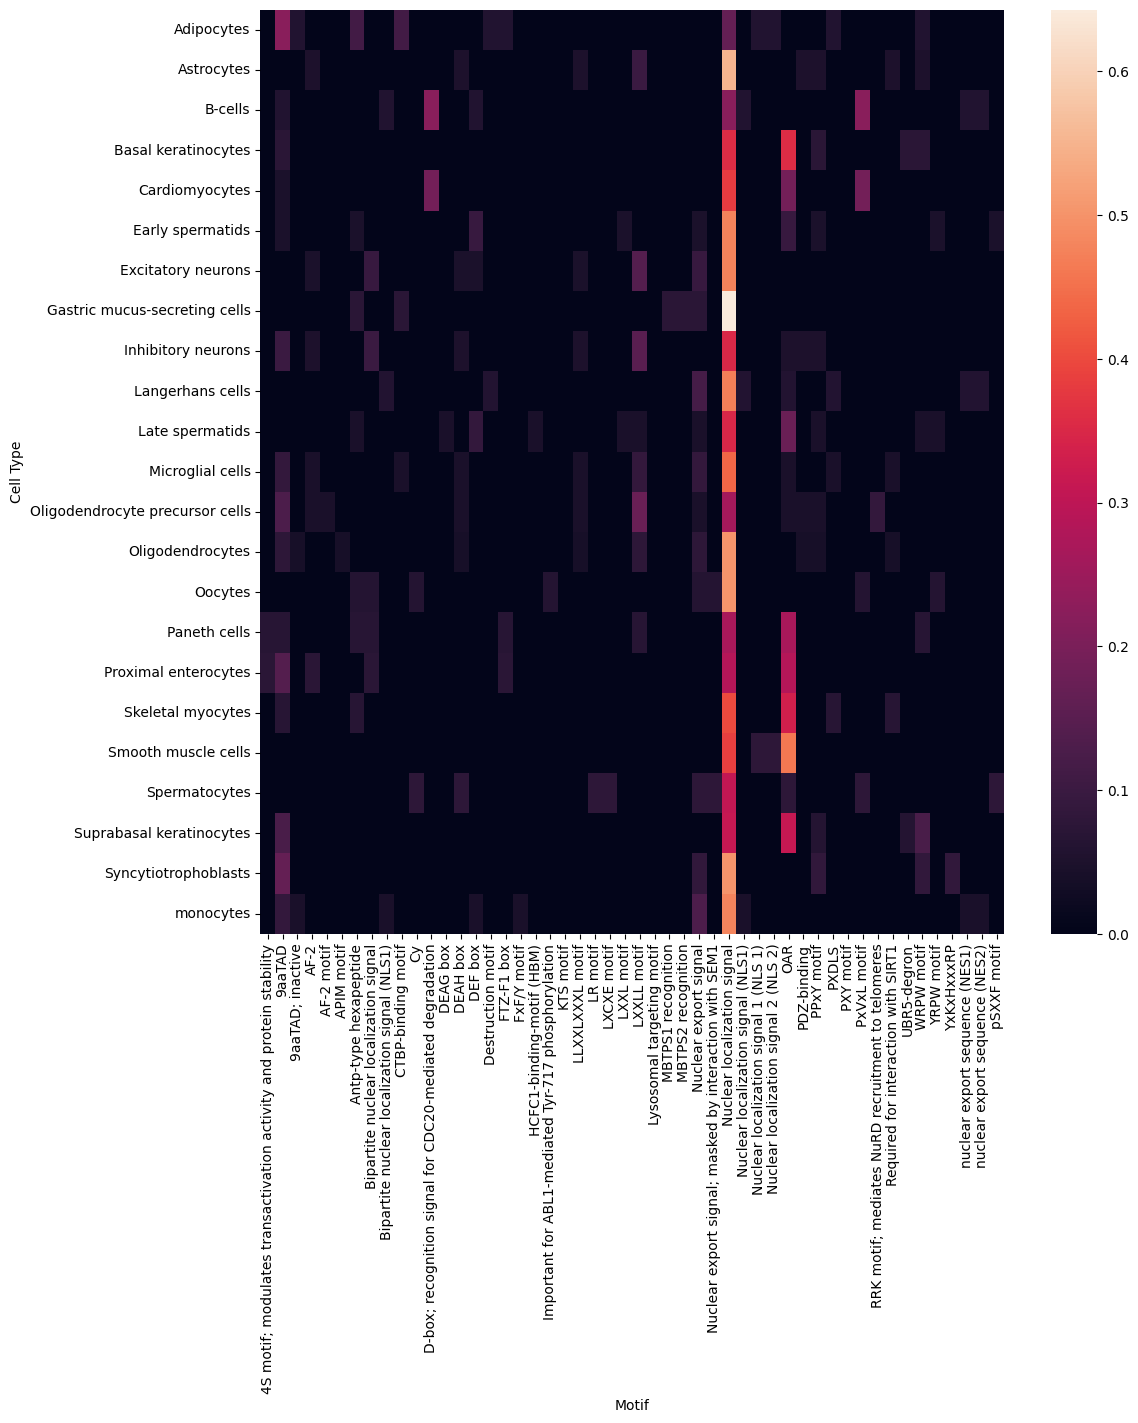

In [188]:
rdTFmotifs = categoricalpivot("Cell Type", "Motif", cleanmotif, rdscellspecific_exploded, True)
rdTFmotifs_filtered = rdTFmotifs[rdTFmotifs.sum(axis=1) > 10]
rdTFmotifs_filtered = rdTFmotifs_filtered.div(rdTFmotifs_filtered.sum(axis=1), axis=0)
plt.figure(figsize=(12, 12))
sns.heatmap(rdTFmotifs_filtered)

<Figure size 1500x2000 with 0 Axes>

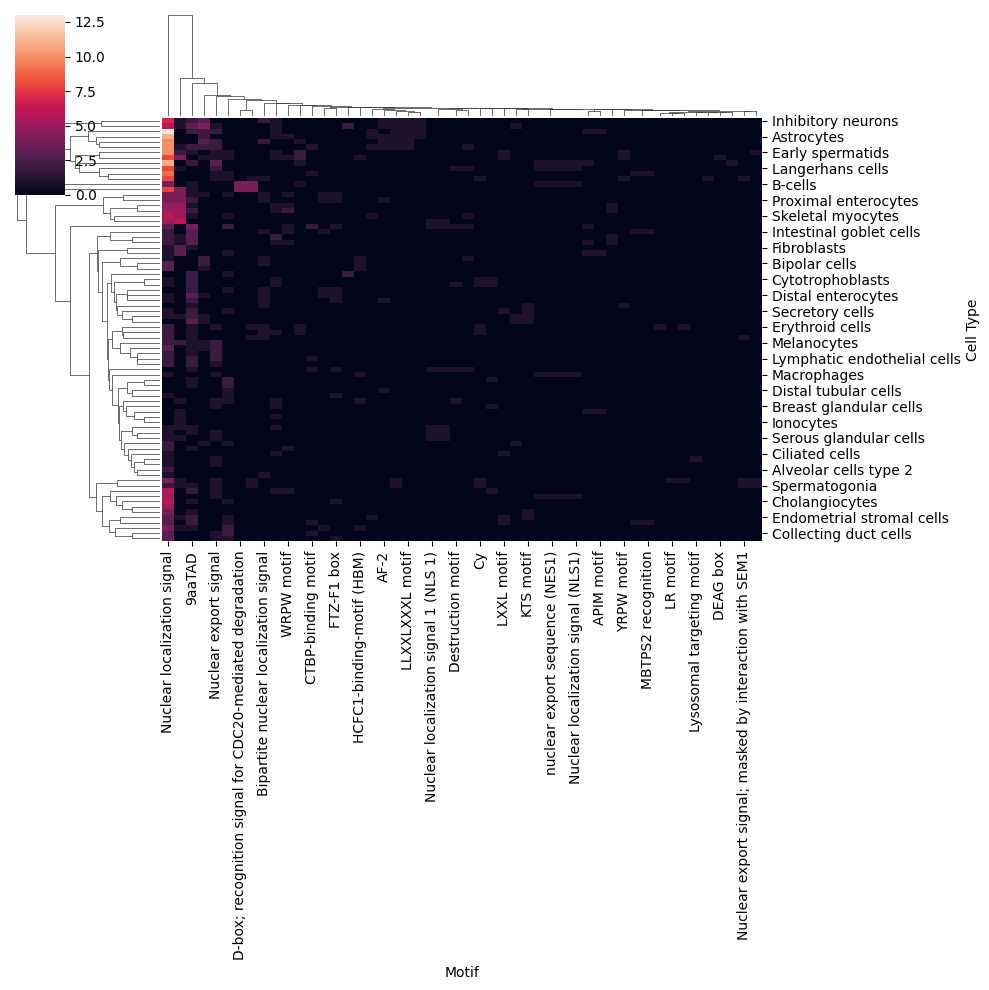

In [146]:
plt.figure(figsize=(15, 20))
sns.clustermap(rdmotifpivot)

In [ ]:
adTFcompbias = adsmapped[["Entry", 'Compositional bias', "Bgee"]]
adTFcompbias[['Comp Bias', 'Positions']] = adsmapped['Compositional bias'].apply(lambda x: pd.Series(cleandomain(str(x))))
adTFcompbias = adTFcompbias.drop("Compositional bias", axis=1)
adTFcompbias["Comp Bias"] = adTFcompbias["Comp Bias"].apply(lambda x:list(set(x)))


adTFcompbias.explode("Comp Bias").groupby("Comp Bias").agg("count").sort_values("Entry", ascending=False)

/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/1372135683.py:2: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  adTFcompbias[['Comp Bias', 'Positions']] = adsmapped['Compositional bias'].apply(lambda x: pd.Series(cleandomain(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/1372135683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adTFcompbias[['Comp Bias', 'Positions']] = adsmapped['Compositional bias'].apply(lambda x: pd.Series(cleandomain(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/1372135683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Entry,Bgee,Positions
Comp Bias,,,
Polar residues,336,335,336
Basic and acidic residues,211,210,211
Pro residues,134,133,134
Acidic residues,49,49,49
Basic residues,33,33,33


/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/350604041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel_64271/350604041.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[[columnlabel, 'Positions']] = df[columnlabel].apply(lambda x: pd.Series(cleanfunction(str(x))))
/var/folders/rq/l7tf3_nx0ml2t2rb_tgxvm280000gn/T/ipykernel

<Figure size 500x1600 with 0 Axes>

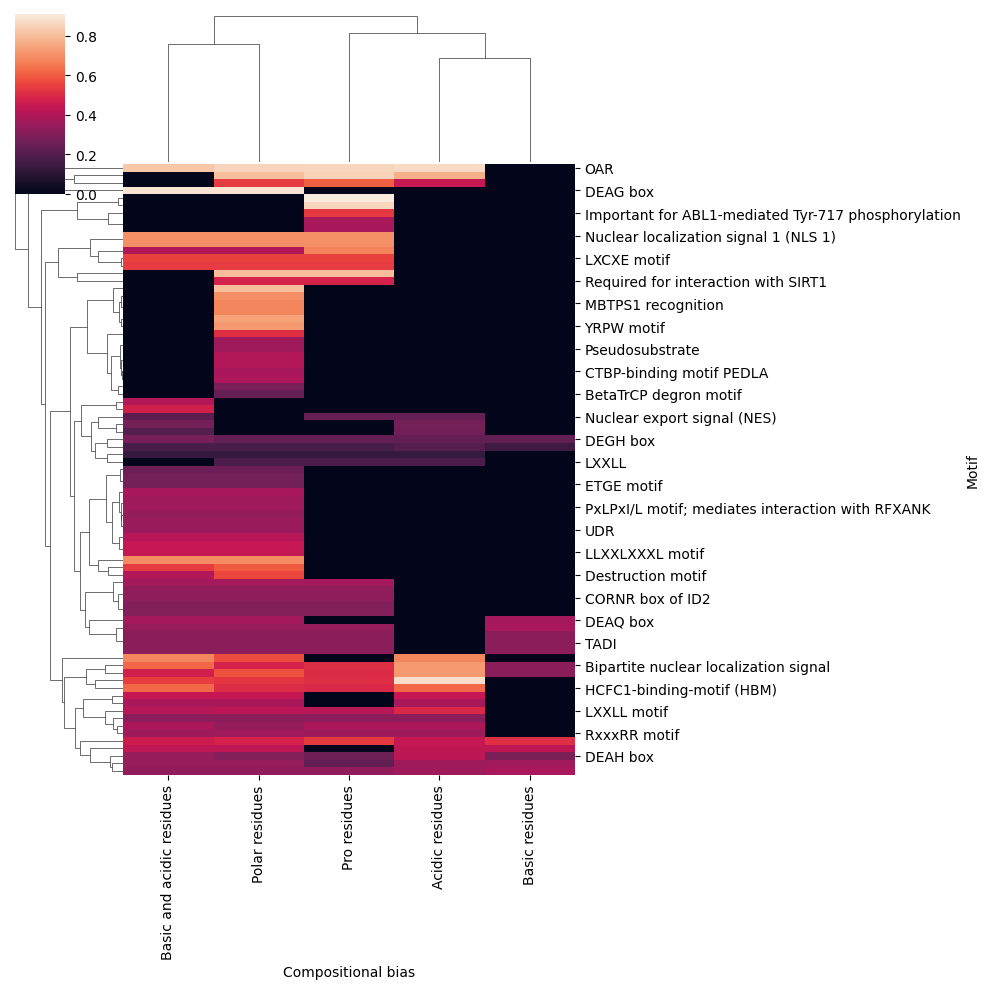

In [232]:
plt.figure(figsize=(5, 16))
sns.clustermap(categoricalpivot_doubleexplode("Motif", "Compositional bias", cleanmotif, rds, True))